In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import minimize

In [2]:

def UZWA(f, g, X0, tau, Nmax, epsilon, type_contrainte='egalite'):
    """
    Résout min f(X) sous g(X) = 0 (ou <= 0) via la méthode d'Uzawa.
    
    Args:
        f: Fonction objectif (h(X))
        g: Fonction contrainte (c(X))
        X0: Point initial
        tau: Pas de mise à jour du multiplicateur (learning rate dual)
        Nmax: Nombre max d'itérations externes
        epsilon: Précision d'arrêt (sur la norme de la contrainte)
        type_contrainte: 'egalite' (g(x)=0) ou 'inegalite' (g(x)<=0)
    
    Returns:
        X: Solution optimale
        lambda_k: Multiplicateur final
        historique: Tableau des [X, lambda] pour analyse
    """
    dim = len(X0)
    X = np.array(X0, dtype=float)
    lam = 0.0 # Initialisation du multiplicateur scalaire (lambda)
    
    history = []
    
    for k in range(Nmax):
        # --- Étape 1 : Minimisation du Lagrangien par rapport à X ---
        # L(X, lam) = f(X) + lam * g(X)
        def lagrangien(x_var):
            return f(x_var) + lam * g(x_var)
        
        # On utilise un solveur rapide (BFGS) pour le sous-problème
        # Pour être purement pédagogique, on pourrait faire une descente de gradient ici aussi
        res = minimize(lagrangien, X, method='BFGS', tol=1e-5)
        X_new = res.x
        
        # Valeur de la contrainte
        gx = g(X_new)
        
        # --- Étape 2 : Mise à jour du multiplicateur (Ascension Duale) ---
        if type_contrainte == 'egalite':
            # Lambda peut être négatif ou positif
            lam_new = lam + tau * gx
        else:
            # Projection sur R+ (Lambda >= 0 pour inégalités)
            lam_new = max(0, lam + tau * gx)
            
        # Stockage
        history.append(np.hstack([X_new, [lam_new]]))
        
        # Critère d'arrêt : Si la contrainte est satisfaite à epsilon près
        # ET que lambda ne bouge plus trop
        if abs(gx) < epsilon and abs(lam_new - lam) < epsilon:
            X = X_new
            lam = lam_new
            break
            
        X = X_new
        lam = lam_new
        
    return X, lam, np.array(history)

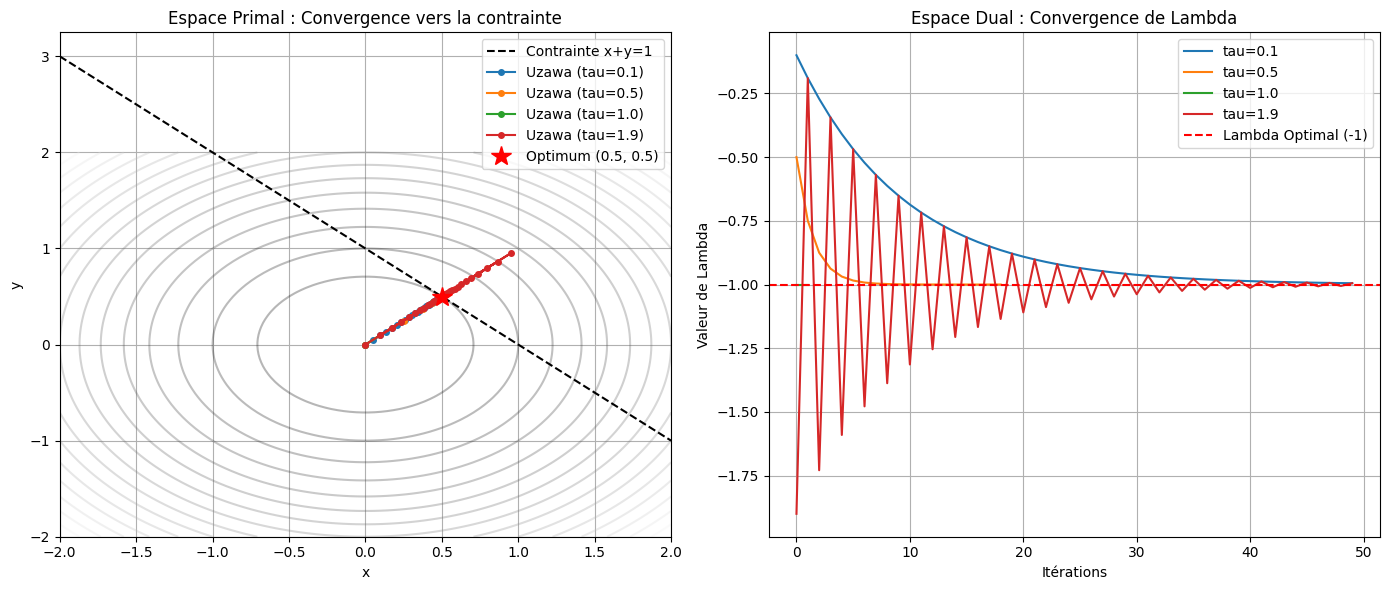

In [3]:
# Définition du problème
def f_test(X): return X[0]**2 + X[1]**2
def g_test(X): return X[0] + X[1] - 1

# Paramètres
X0 = [-1.5, -1.5]
tau_vals = [0.1, 0.5, 1.0, 1.9] # Différents pas pour analyser la convergence

plt.figure(figsize=(14, 6))

# --- Graphique 1 : Trajectoires dans l'espace primal (x, y) ---
plt.subplot(1, 2, 1)

# Fond (Isolignes de f)
x_grid = np.linspace(-2, 2, 100)
y_grid = np.linspace(-2, 2, 100)
X_g, Y_g = np.meshgrid(x_grid, y_grid)
plt.contour(X_g, Y_g, X_g**2 + Y_g**2, levels=15, cmap='gray', alpha=0.3)
plt.plot(x_grid, 1-x_grid, 'k--', label='Contrainte x+y=1')

for tau in tau_vals:
    sol, lam_f, hist = UZWA(f_test, g_test, X0, tau=tau, Nmax=50, epsilon=1e-6)
    plt.plot(hist[:, 0], hist[:, 1], 'o-', markersize=4, label=f'Uzawa (tau={tau})')

plt.plot(0.5, 0.5, 'r*', markersize=15, label='Optimum (0.5, 0.5)')
plt.title("Espace Primal : Convergence vers la contrainte")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()

# --- Graphique 2 : Convergence du Multiplicateur Lambda ---
plt.subplot(1, 2, 2)
for tau in tau_vals:
    sol, lam_f, hist = UZWA(f_test, g_test, X0, tau=tau, Nmax=50, epsilon=1e-6)
    plt.plot(hist[:, 2], label=f'tau={tau}')

plt.axhline(-1, color='red', linestyle='--', label='Lambda Optimal (-1)')
plt.title("Espace Dual : Convergence de Lambda")
plt.xlabel("Itérations")
plt.ylabel("Valeur de Lambda")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Calcul en cours........ Terminé !

--- RÉSULTATS COMPARATIFS ---
 Tau  Itérations  Temps (s)  Err Finale X  Lambda Final
 0.1         100     0.1526  2.383274e-05          -1.0
 0.5          19     0.0254  3.564902e-09          -1.0
 1.0           2     0.0032  3.878486e-08          -1.0
 1.5         100     0.0958  7.582981e-06          -1.0
 1.9         100     0.1333  2.048397e-05          -1.0


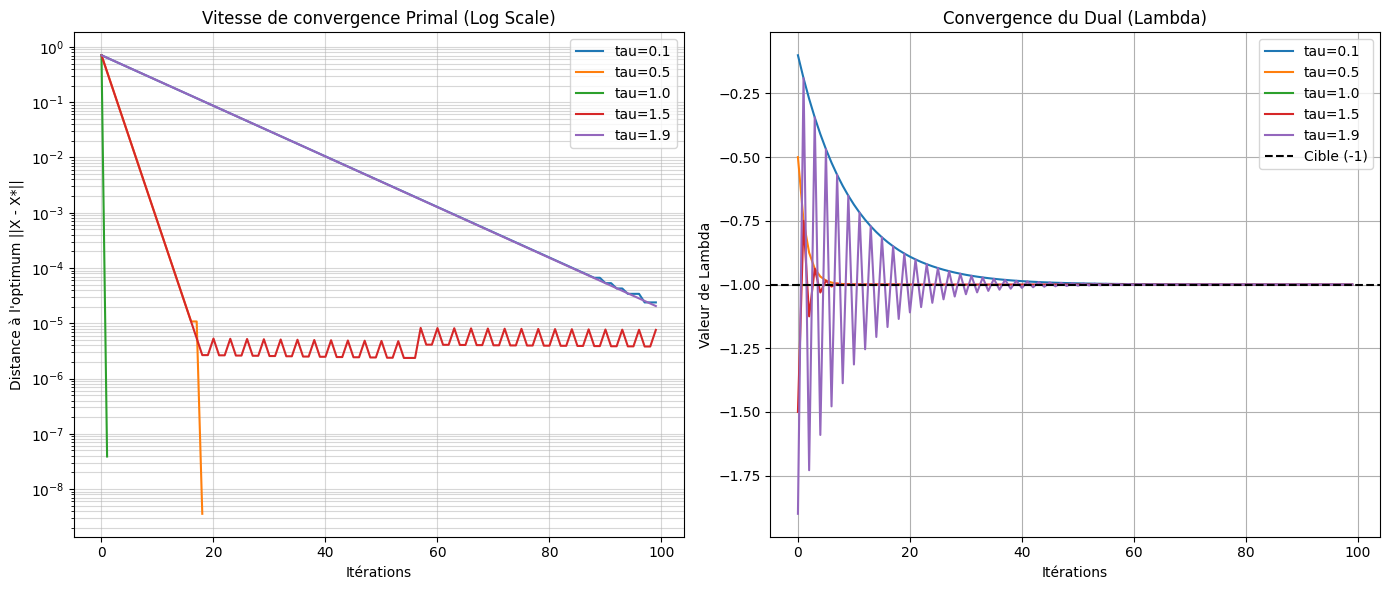

In [4]:
# --- 1. Définition du Problème ---
# Objectif : min x^2 + y^2 sous x + y = 1
# Optimum théorique : x=0.5, y=0.5, lambda=-1

THEORIQUE_X = np.array([0.5, 0.5])
THEORIQUE_LAM = -1.0

def f(X): 
    return X[0]**2 + X[1]**2

def g(X): 
    return X[0] + X[1] - 1  # = 0

# --- 2. Algorithme d'Uzawa Instrumenté ---
def uzawa_benchmark(tau, X0, Nmax, epsilon):
    X = np.array(X0, dtype=float)
    lam = 0.0 # Initialisation lambda
    
    history_err_X = []
    history_err_G = []
    history_lam = []
    
    start_time = time.time()
    iters = Nmax
    
    for k in range(Nmax):
        # A. Minimisation du Lagrangien par rapport à X
        # L(X) = f(X) + lam * g(X)
        fun_L = lambda x_var: f(x_var) + lam * g(x_var)
        
        # Résolution du sous-problème (BFGS est rapide et précis)
        res = minimize(fun_L, X, method='BFGS', tol=1e-5)
        X_new = res.x
        
        # B. Mise à jour du multiplicateur (Gradient Ascent sur le Dual)
        val_g = g(X_new)
        lam_new = lam + tau * val_g
        
        # C. Enregistrement des métriques
        dist_opt = np.linalg.norm(X_new - THEORIQUE_X)
        history_err_X.append(dist_opt)
        history_err_G.append(abs(val_g))
        history_lam.append(lam_new)
        
        # D. Critère d'arrêt
        if abs(val_g) < epsilon and abs(lam_new - lam) < epsilon:
            iters = k + 1
            break
            
        X = X_new
        lam = lam_new
        
    duration = time.time() - start_time
    
    return {
        "Tau": tau,
        "Itérations": iters,
        "Temps (s)": round(duration, 4),
        "Err Finale X": history_err_X[-1],
        "Err Contrainte": history_err_G[-1],
        "Lambda Final": round(lam, 4),
        "Hist_Err_X": history_err_X,
        "Hist_Lam": history_lam
    }

# --- 3. Exécution du Benchmark ---
taus_to_test = [0.1, 0.5, 1.0, 1.5, 1.9] # On teste du lent au rapide
X0 = [-2.0, -2.0]
Nmax = 100
epsilon = 1e-6

results = []
print("Calcul en cours...", end="")
for tau in taus_to_test:
    res = uzawa_benchmark(tau, X0, Nmax, epsilon)
    results.append(res)
    print(".", end="")
print(" Terminé !")

# --- 4. Affichage Tableau ---
df = pd.DataFrame(results)
cols_show = ["Tau", "Itérations", "Temps (s)", "Err Finale X", "Lambda Final"]
print("\n--- RÉSULTATS COMPARATIFS ---")
print(df[cols_show].to_string(index=False))

# --- 5. Visualisation Graphique ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphe 1 : Convergence vers la solution (Distance X - X*)
for res in results:
    ax1.plot(res["Hist_Err_X"], label=f'tau={res["Tau"]}')

ax1.set_yscale('log') # Échelle log pour mieux voir la convergence
ax1.set_title("Vitesse de convergence Primal (Log Scale)")
ax1.set_xlabel("Itérations")
ax1.set_ylabel("Distance à l'optimum ||X - X*||")
ax1.legend()
ax1.grid(True, which="both", ls="-", alpha=0.5)

# Graphe 2 : Stabilité du Multiplicateur Lambda
for res in results:
    ax2.plot(res["Hist_Lam"], label=f'tau={res["Tau"]}')

ax2.axhline(THEORIQUE_LAM, color='black', linestyle='--', label='Cible (-1)')
ax2.set_title("Convergence du Dual (Lambda)")
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de Lambda")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

Iter  | X                    | Lambda     | g(x)      
------------------------------------------------------------
0     | [0.2 0.2]            | -0.0600     | -6.00e-01
10    | [1.296 1.296]        | 0.8049     | 1.59e+00
20    | [1.202 1.202]        | 2.4182     | 1.40e+00
30    | [0.75 0.75]          | 3.3284     | 5.00e-01
40    | [0.443 0.443]        | 3.4495     | -1.14e-01
50    | [0.37 0.37]          | 3.2231     | -2.60e-01
60    | [0.422 0.422]        | 3.0109     | -1.56e-01
70    | [0.487 0.487]        | 2.9304     | -2.62e-02
80    | [0.517 0.517]        | 2.9439     | 3.46e-02
90    | [0.518 0.518]        | 2.9821     | 3.51e-02
100   | [0.507 0.507]        | 3.0062     | 1.43e-02
110   | [0.499 0.499]        | 3.0108     | -1.50e-03
120   | [0.497 0.497]        | 3.0060     | -6.11e-03
130   | [0.498 0.498]        | 3.0007     | -4.07e-03
140   | [0.5 0.5]            | 2.9985     | -9.25e-04

>>> CONVERGENCE à l'itération 144

Point final : [0.49997709 0.49997709]
Multi

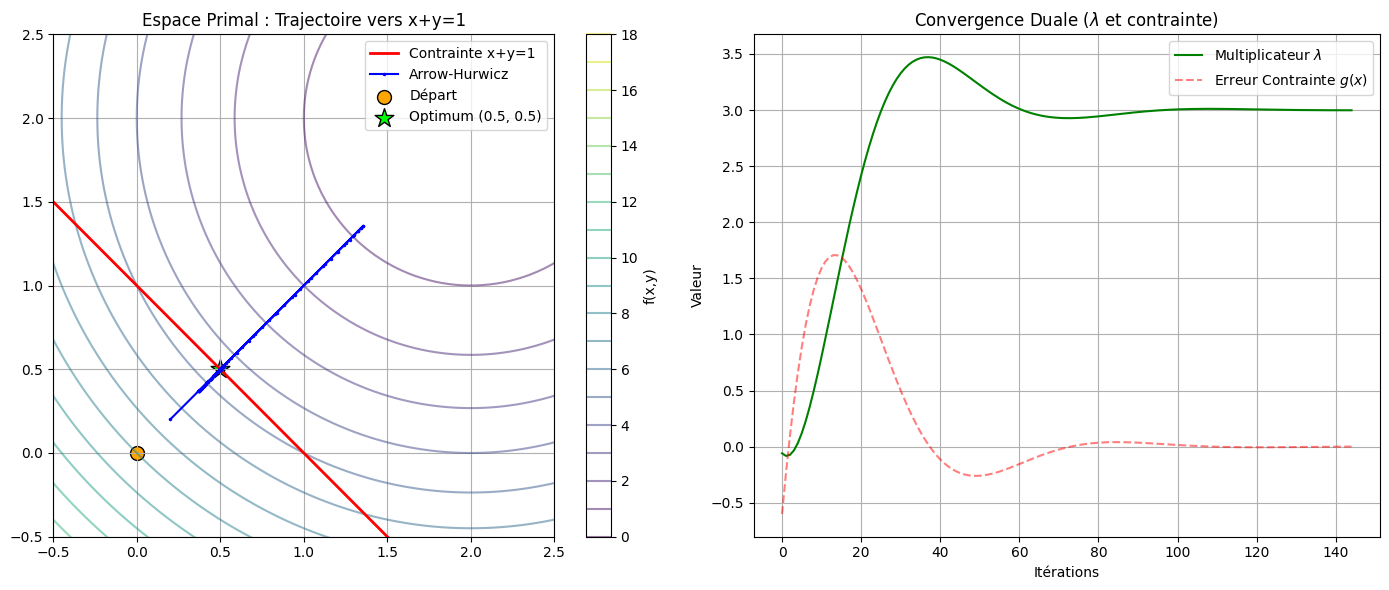

In [ ]:
# Min f(x,y) = (x-2)^2 + (y-2)^2
# Sous contrainte : x + y = 1  => g(x) = x + y - 1 = 0

def f(X):
    return (X[0]-2)**2 + (X[1]-2)**2

def grad_f(X):
    return np.array([2*(X[0]-2), 2*(X[1]-2)])

def g_func(X):
    return X[0] + X[1] - 1

def grad_g(X):
    return np.array([1.0, 1.0])

# --- 2. Algorithme d'Arrow-Hurwicz  ---
def ArrowHurwicz(X0, lam0, alpha, rho, Nmax, epsilon):
    """
    Arrow-Hurwicz avec arrêt basé sur la satisfaction de contrainte et stabilité de lambda.
    Contrainte d'égalité : lambda n'est pas projeté.
    """
    X = np.array(X0, dtype=float)
    lam = lam0
    
    history = []
    
    print(f"{'Iter':<5} | {'X':<20} | {'Lambda':<10} | {'g(x)':<10}")
    print("-" * 60)
    
    for k in range(Nmax):
        # 1. Calcul du Gradient du Lagrangien par rapport à X
        # Grad_x L(x, lambda) = Grad f(x) + lambda * Grad g(x)
        grad_L_x = grad_f(X) + lam * grad_g(X)
        
        # 2. Mise à jour de X (Un seul pas de descente)
        X_new = X - alpha * grad_L_x
        
        # 3. Mise à jour de Lambda (Ascension)
        # Pour égalité g(x)=0 : lambda = lambda + rho * g(x)
        # (Pas de max(0, ...) car lambda peut être négatif pour une égalité)
        val_g = g_func(X_new)
        lam_new = lam + rho * val_g
        
        # Stockage
        history.append({
            'k': k, 'x': X_new[0], 'y': X_new[1], 
            'lambda': lam_new, 'g_val': val_g
        })
        
        if k % 10 == 0:
            print(f"{k:<5} | {str(np.round(X_new,3)):<20} | {lam_new:.4f}     | {val_g:.2e}")

        # --- CRITÈRE D'ARRÊT SIMPLIFIÉ  ---
        # 1. La contrainte est-elle respectée ? (|g(x)| < eps)
        # 2. Le multiplicateur est-il stable ? (|lam_new - lam| < eps)
        if abs(val_g) < epsilon and abs(lam_new - lam) < epsilon:
            print(f"\n>>> CONVERGENCE à l'itération {k}")
            return X_new, lam_new, pd.DataFrame(history)
            
        X = X_new
        lam = lam_new
        
    print("\n>>> Arrêt : Nombre Max d'itérations atteint.")    
    return X, lam, pd.DataFrame(history)

# --- 3. Exécution ---
# Paramètres
X0 = [0.0, 0.0]  # Point de départ
lam0 = 0.0       # Lambda initial
Nmax = 500
epsilon = 1e-4

# ATTENTION : Arrow-Hurwicz est très sensible aux pas alpha et rho.
# Il faut souvent alpha petit par rapport à rho pour éviter les oscillations.
alpha = 0.05     # Pas primal (pour X)
rho = 0.1        # Pas dual (pour Lambda)

X_sol, lam_sol, df = ArrowHurwicz(X0, lam0, alpha, rho, Nmax, epsilon)

print(f"\nPoint final : {X_sol}")
print(f"Multiplicateur Lambda final : {lam_sol}")
print(f"Valeur contrainte finale : {g_func(X_sol)}")

# --- 4. Visualisation ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# A. Trajectoire dans l'espace (Espace Primal)
x_grid = np.linspace(-1, 3, 100)
y_grid = np.linspace(-1, 3, 100)
Xg, Yg = np.meshgrid(x_grid, y_grid)
Zg = (Xg-2)**2 + (Yg-2)**2 # Fonction objectif

# Contours f(x)
cp = ax1.contour(Xg, Yg, Zg, levels=20, cmap='viridis', alpha=0.5)
plt.colorbar(cp, ax=ax1, label='f(x,y)')

# Contrainte x+y=1 (droite)
ax1.plot(x_grid, 1 - x_grid, 'r-', linewidth=2, label='Contrainte x+y=1')

# Trajectoire algorithme
ax1.plot(df['x'], df['y'], 'b.-', markersize=3, label='Arrow-Hurwicz')
ax1.scatter(X0[0], X0[1], c='orange', s=100, label='Départ', edgecolors='k')
# Optimum théorique pour x+y=1 => (0.5, 0.5)
ax1.scatter(0.5, 0.5, c='lime', marker='*', s=200, label='Optimum (0.5, 0.5)', edgecolors='k')

ax1.set_title("Espace Primal : Trajectoire vers x+y=1")
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 2.5)
ax1.legend()
ax1.grid(True)

# B. Évolution de Lambda (Espace Dual)
# Utilisation de r"..." pour éviter les SyntaxWarning avec LaTeX
ax2.plot(df['k'], df['lambda'], 'g-', label=r'Multiplicateur $\lambda$')
ax2.plot(df['k'], df['g_val'], 'r--', label=r'Erreur Contrainte $g(x)$', alpha=0.5)

ax2.set_xlabel('Itérations')
ax2.set_ylabel(r'Valeur')
ax2.set_title(r"Convergence Duale ($\lambda$ et contrainte)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

>>> Démarrage du Benchmark...
Exécution d'Uzawa... Terminé (0.0037s)
Exécution d'Arrow-Hurwicz...Iter  | X                    | Lambda     | g(x)      
------------------------------------------------------------
0     | [0.2 0.2]            | -0.0600     | -6.00e-01
10    | [1.296 1.296]        | 0.8049     | 1.59e+00
20    | [1.202 1.202]        | 2.4182     | 1.40e+00
30    | [0.75 0.75]          | 3.3284     | 5.00e-01
40    | [0.443 0.443]        | 3.4495     | -1.14e-01
50    | [0.37 0.37]          | 3.2231     | -2.60e-01
60    | [0.422 0.422]        | 3.0109     | -1.56e-01
70    | [0.487 0.487]        | 2.9304     | -2.62e-02
80    | [0.517 0.517]        | 2.9439     | 3.46e-02
90    | [0.518 0.518]        | 2.9821     | 3.51e-02
100   | [0.507 0.507]        | 3.0062     | 1.43e-02
110   | [0.499 0.499]        | 3.0108     | -1.50e-03
120   | [0.497 0.497]        | 3.0060     | -6.11e-03
130   | [0.498 0.498]        | 3.0007     | -4.07e-03
140   | [0.5 0.5]            | 2.998

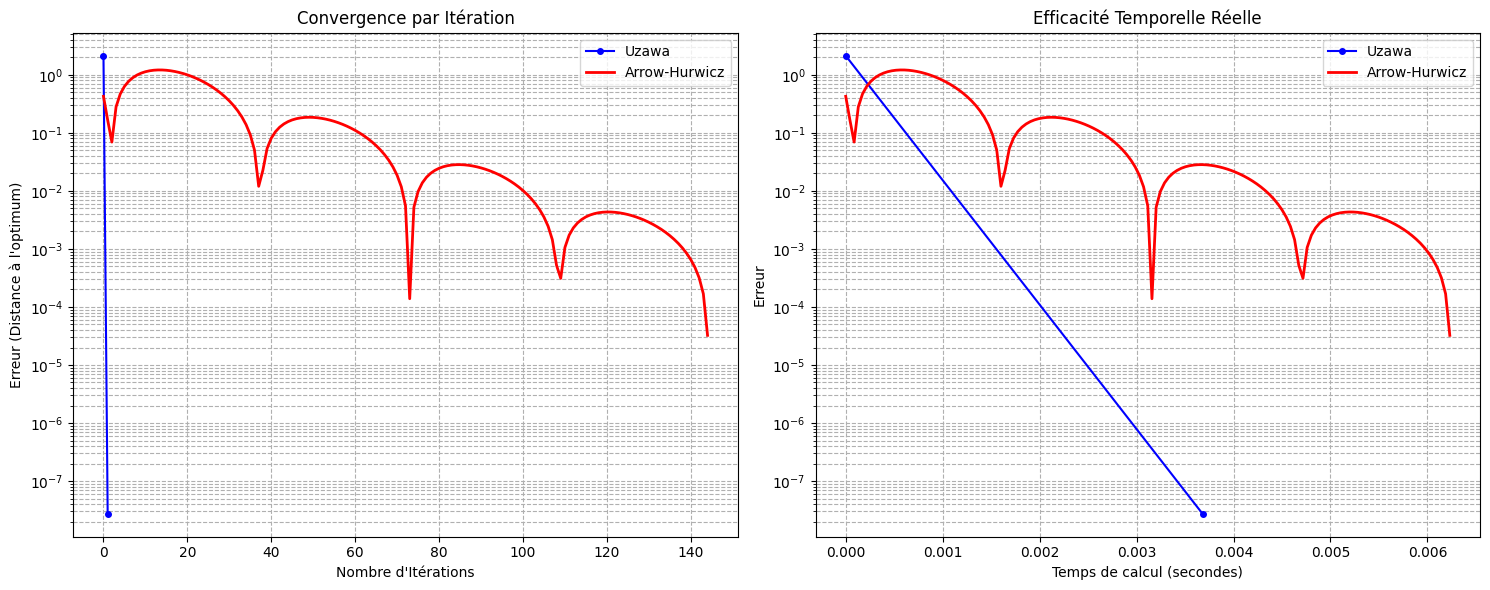

In [9]:
def run_benchmark():
    # Paramètres communs
    X0 = [0.0, 0.0]
    EPSILON = 1e-4
    
    print(">>> Démarrage du Benchmark...")

    # --- TEST UZAWA ---
    print("Exécution d'Uzawa...", end="")
    start_u = time.perf_counter()
    
    # Appel de VOTRE fonction UZWA
    sol_u, lam_u, hist_u_raw = UZWA(f, g, X0, tau=1.0, Nmax=100, epsilon=EPSILON)
    
    end_u = time.perf_counter()
    time_u = end_u - start_u
    print(f" Terminé ({time_u:.4f}s)")
    
    # Traitement des données Uzawa pour affichage
    # hist_u_raw est un np.array [[x1, x2, lam], ...]
    df_u = pd.DataFrame(hist_u_raw, columns=['x', 'y', 'lambda'])
    df_u['iter'] = range(len(df_u))
    # Calcul distance optimum pour chaque itération
    df_u['dist'] = np.sqrt((df_u['x'] - THEORIQUE_X[0])**2 + (df_u['y'] - THEORIQUE_X[1])**2)


    # --- TEST ARROW-HURWICZ ---
    print("Exécution d'Arrow-Hurwicz...", end="")
    start_ah = time.perf_counter()
    
    # Appel de VOTRE fonction ArrowHurwicz
    # Attention: AH nécessite beaucoup plus d'itérations, on met Nmax=2000
    sol_ah, lam_ah, df_ah = ArrowHurwicz(X0, lam0=0.0, alpha=0.05, rho=0.1, Nmax=2000, epsilon=EPSILON)
    
    end_ah = time.perf_counter()
    time_ah = end_ah - start_ah
    print(f" Terminé ({time_ah:.4f}s)")
    
    # Calcul distance optimum pour Arrow-Hurwicz
    df_ah['dist'] = np.sqrt((df_ah['x'] - THEORIQUE_X[0])**2 + (df_ah['y'] - THEORIQUE_X[1])**2)
    # On ajoute une colonne temps estimé cumulé pour le graphe temporel
    # On approxime que chaque itération prend (temps_total / nb_iters)
    df_ah['time_cum'] = np.linspace(0, time_ah, len(df_ah))
    df_u['time_cum'] = np.linspace(0, time_u, len(df_u))

    return df_u, df_ah, time_u, time_ah

# ==============================================================================
# . AFFICHAGE ET VISUALISATION
# ==============================================================================

df_uzawa, df_arrow, t_uzawa, t_arrow = run_benchmark()

# --- Tableau Récapitulatif ---
print("\n" + "="*50)
print(f"{'MÉTHODE':<15} | {'ITÉRATIONS':<10} | {'TEMPS (s)':<10} | {'PRÉCISION X'}")
print("-" * 50)
print(f"{'Uzawa':<15} | {len(df_uzawa):<10} | {t_uzawa:.5f}     | {df_uzawa.iloc[-1]['dist']:.2e}")
print(f"{'Arrow-Hurwicz':<15} | {len(df_arrow):<10} | {t_arrow:.5f}     | {df_arrow.iloc[-1]['dist']:.2e}")
print("="*50 + "\n")

# --- Graphiques ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1 : Vitesse par ITÉRATION
ax1.plot(df_uzawa['iter'], df_uzawa['dist'], 'b-o', markersize=4, label='Uzawa')
ax1.plot(df_arrow['k'], df_arrow['dist'], 'r-', linewidth=2, label='Arrow-Hurwicz')
ax1.set_yscale('log')
ax1.set_xlabel("Nombre d'Itérations")
ax1.set_ylabel("Erreur (Distance à l'optimum)")
ax1.set_title("Convergence par Itération")
ax1.legend()
ax1.grid(True, which="both", linestyle='--')

# Graphique 2 : Vitesse par TEMPS RÉEL (Wall clock)
ax2.plot(df_uzawa['time_cum'], df_uzawa['dist'], 'b-o', markersize=4, label='Uzawa')
ax2.plot(df_arrow['time_cum'], df_arrow['dist'], 'r-', linewidth=2, label='Arrow-Hurwicz')
ax2.set_yscale('log')
ax2.set_xlabel("Temps de calcul (secondes)")
ax2.set_ylabel("Erreur")
ax2.set_title("Efficacité Temporelle Réelle")
ax2.legend()
ax2.grid(True, which="both", linestyle='--')

plt.tight_layout()
plt.show()